<a href="https://colab.research.google.com/github/tdraths/employee_attrtition/blob/main/employee_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I. Loading Packages & Examining the Data

In [1]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.  Downloading shap-0.39.0-cp37-cp37m-win_amd64.whl (414 kB)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
pip install xgboost

  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)



In [5]:
# Pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Modelling the Data
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Improving the Model
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection

# Checking performance
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer

In [43]:
# Read data
data = pd.read_csv('https://raw.githubusercontent.com/Premkumar7090/Predicting_employee_attrition/projects/data.csv')
df = data.copy()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [12]:
df

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,2,Sales Executive,4,Single,5993,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,2,Research Scientist,2,Married,5130,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,1,Laboratory Technician,3,Single,2090,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,1,Research Scientist,3,Married,2909,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,1,Laboratory Technician,2,Married,3468,9,0,12,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,Research & Development,23,2,Medical,3,Male,4,2,Laboratory Technician,4,Married,2571,4,0,17,3,3,1,17,3,3,5,2,0,3
1466,39,0,Travel_Rarely,Research & Development,6,1,Medical,4,Male,2,3,Healthcare Representative,1,Married,9991,4,0,15,3,1,1,9,5,3,7,7,1,7
1467,27,0,Travel_Rarely,Research & Development,4,3,Life Sciences,2,Male,4,2,Manufacturing Director,2,Married,6142,1,1,20,4,2,1,6,0,3,6,2,0,3
1468,49,0,Travel_Frequently,Sales,2,3,Medical,4,Male,2,2,Sales Executive,2,Married,5390,2,0,14,3,4,0,17,3,2,9,6,0,8


There are 34 features and one target variable, `attrition`.

In [8]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Looking at the table above, quite a few of the dataset features have ranges of 1 - 4 or 1 - 5, representing on a small scale how an employee perceives their environment, job involvement, etc.

`EmployeeCount`, `Over18`, and `StandardHours` all have only one value distributed across the entire column. I'll drop those three features. Similarly, `EmployeeNumber` is an unique identifier for each employee, and I won't use it in my analysis and modelling.

Some of the numerical features represent salary or income rates, but it isn't clear what they necessarily mean. I'm going to select one that seems to most accurately represent an employee's income - `MonthlyIncome`. The remaining salary/income features will be dropped.

In [9]:
df.columns = map(str.lower, df.columns)
df.drop(columns=['employeenumber', 'employeecount', 'over18', 'standardhours', 
                 'dailyrate', 'hourlyrate', 'monthlyrate'], inplace=True)

The `attrition` target variable contains 'Yes' and 'No' as values; I'll encode these as binary values instead, with 'Yes' = 1, and 'No' = 0. I'll do the same with `overtime`.

In [10]:
df['attrition'] = df['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df['overtime'] = df['overtime'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
print(f"Count of Rows: {df.shape[0]} \n")
print(f"Count of Features: {df.shape[1]} \n")
print(f"Missing Data: {df.isna().values.sum()} \n")
print(f"Unique values: {df.nunique()}")

Count of Rows: 1470 

Count of Features: 28 

Missing Data: 0 

Unique values: age                           43
attrition                      2
businesstravel                 3
department                     3
distancefromhome              29
education                      5
educationfield                 6
environmentsatisfaction        4
gender                         2
jobinvolvement                 4
joblevel                       5
jobrole                        9
jobsatisfaction                4
maritalstatus                  3
monthlyincome               1349
numcompaniesworked            10
overtime                       2
percentsalaryhike             15
performancerating              2
relationshipsatisfaction       4
stockoptionlevel               4
totalworkingyears             40
trainingtimeslastyear          7
worklifebalance                4
yearsatcompany                37
yearsincurrentrole            19
yearssincelastpromotion       16
yearswithcurrmanager          

 **Target feature:** 
 - Attrition

**Numerical features:**
 - Age
 - DistanceFromHome
 - Education
 - EnvironmentSatisfaction
 - JobInvolvement
 - JobLevel
 - JobSatisfaction
 - MonthlyIncome
 - NumCompaniesWorked
 - PercentSalaryHike
 - PerformanceRating
 - RelationshipSatisfaction
 - StockOptionLevel
 - TotalWorkingYears
 - TrainingTimesLastYear
 - WorkLifeBalance
 - YearsAtCompany
 - YearsInCurrentRole
 - YearsSinceLastPromotion
 - YearsWithCurrManager
 - OverTime

**Categorical features:**
 - BusinessTravel
 - Department
 - EducationField
 - Gender
 - JobRole
 - MaritalStatus



In [13]:
df.to_csv('use_data.csv')

#### What's Happened So Far:
 - We have a target variable `attrition` binarily coded.
 - We have 27 features to use to predict attrition, and we'll have a look at the distributions of data across those features below.
 - The dataset was already pretty cleaned up, with no missing values, so there really wasn't a lot to do here.

#### Next Steps:
 - Visualizing distributions and attrition rate
 - Preprocessing and modelling
 - Tuning Parameters
 - Finalizing Results!

## II. Visualizing Distributions & Attrition Rates

In [14]:
numerical = ['age', 'distancefromhome', 'education', 'environmentsatisfaction', 'jobinvolvement', 
             'joblevel', 'jobsatisfaction', 'monthlyincome', 'numcompaniesworked', 'percentsalaryhike',
             'performancerating', 'relationshipsatisfaction', 'stockoptionlevel', 'totalworkingyears',
             'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany', 'yearsincurrentrole', 
             'yearssincelastpromotion', 'yearswithcurrmanager', 'overtime']

categorical = ['businesstravel', 'department', 'educationfield', 'gender', 'jobrole', 'maritalstatus']

In [15]:
def plot_categorical(df, var_name, target_name, width=7, height=5):
  population_ratio = round(df.loc[:, target_name].mean(), 5)
  target_proportion = df.loc[:, [target_name, var_name]].groupby([var_name]).mean()
  print(target_proportion*100.)

  categorical_distribution = df.loc[:, [target_name, var_name]].groupby([var_name]).count()

  fig = plt.figure(figsize=(width, height))
  ax = categorical_distribution[target_name].plot(kind='bar')
  ax.set_ylabel('Number of Samples', color='black')
  ax2 = ax.twinx()
  ax2.grid(False)
  ax2.plot(target_proportion[target_name].values, color='darkorange', linestyle='-',
           alpha=0.9, marker='.', markeredgewidth=2, linewidth=3.0)
  ax2.set_ylabel('Target Ratio')
  plt.title('Description of Variable {0}\n Attrition Rate for: {1}'.format(var_name, population_ratio))
  plt.tight_layout();

def plot_continuous(df, var_name, target_name, width=7, height=5, bins='auto'):
  plot_categorical(df, var_name, target_name, width=7, height=5);

                   attrition
businesstravel              
Non-Travel          8.000000
Travel_Frequently  24.909747
Travel_Rarely      14.956855


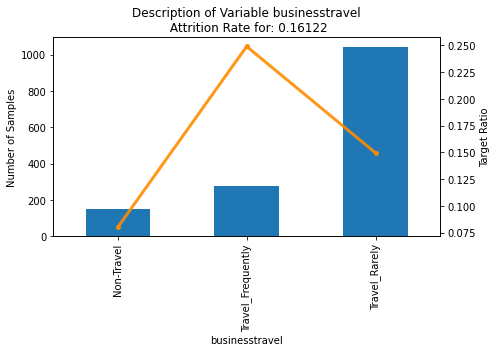

In [16]:
plot_categorical(df, 'businesstravel', 'attrition')

                        attrition
department                       
Human Resources         19.047619
Research & Development  13.839750
Sales                   20.627803


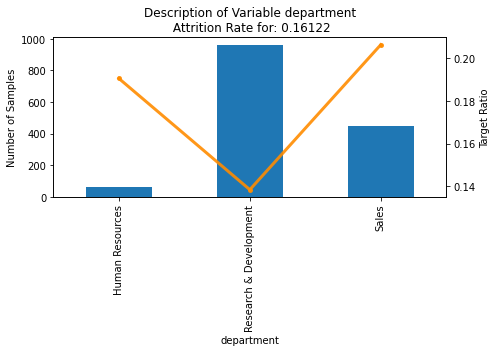

In [17]:
plot_categorical(df, 'department', 'attrition')

                  attrition
educationfield             
Human Resources   25.925926
Life Sciences     14.686469
Marketing         22.012579
Medical           13.577586
Other             13.414634
Technical Degree  24.242424


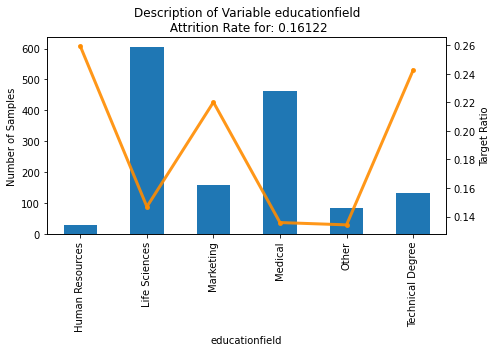

In [18]:
plot_categorical(df, 'educationfield', 'attrition')

        attrition
gender           
Female  14.795918
Male    17.006803


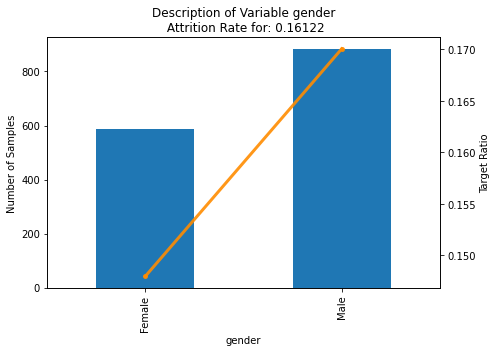

In [19]:
plot_categorical(df, 'gender', 'attrition')

                           attrition
jobrole                             
Healthcare Representative   6.870229
Human Resources            23.076923
Laboratory Technician      23.938224
Manager                     4.901961
Manufacturing Director      6.896552
Research Director           2.500000
Research Scientist         16.095890
Sales Executive            17.484663
Sales Representative       39.759036


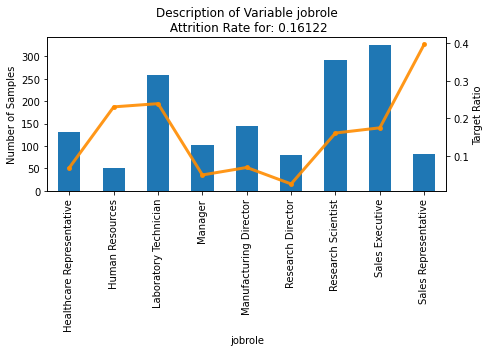

In [ ]:
plot_categorical(df, 'jobrole', 'attrition')


               attrition
maritalstatus           
Divorced       10.091743
Married        12.481426
Single         25.531915


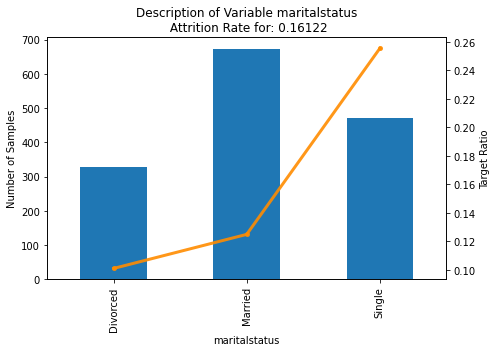

In [ ]:
plot_categorical(df, 'maritalstatus', 'attrition')

     attrition
age           
18   50.000000
19   66.666667
20   54.545455
21   46.153846
22   31.250000
23   28.571429
24   26.923077
25   23.076923
26   30.769231
27    6.250000
28   29.166667
29   26.470588
30   15.000000
31   26.086957
32   18.032787
33   20.689655
34   11.688312
35   12.820513
36    8.695652
37   12.000000
38    3.448276
39   14.285714
40    8.771930
41   15.000000
42    4.347826
43    6.250000
44   18.181818
45    4.878049
46   12.121212
47   12.500000
48   10.526316
49    8.333333
50   16.666667
51   10.526316
52   16.666667
53   10.526316
54    0.000000
55   13.636364
56   21.428571
57    0.000000
58   35.714286
59    0.000000
60    0.000000


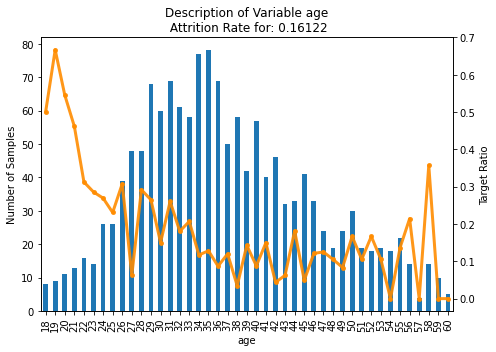

In [ ]:
plot_continuous(df, 'age', 'attrition', bins=10)

                  attrition
distancefromhome           
1                 12.500000
2                 13.270142
3                 16.666667
4                 14.062500
5                 15.384615
6                 11.864407
7                 13.095238
8                 12.500000
9                 21.176471
10                12.790698
11                13.793103
12                30.000000
13                31.578947
14                19.047619
15                19.230769
16                21.875000
17                25.000000
18                15.384615
19                13.636364
20                16.000000
21                16.666667
22                31.578947
23                18.518519
24                42.857143
25                24.000000
26                12.000000
27                25.000000
28                 8.695652
29                18.518519


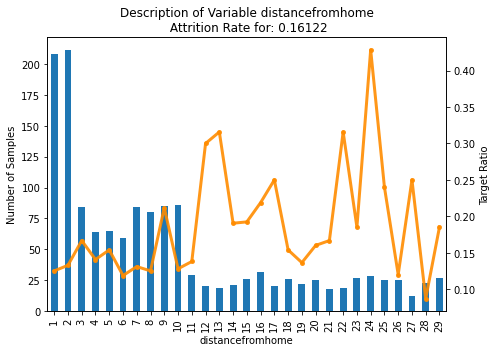

In [ ]:
plot_continuous(df, 'distancefromhome', 'attrition')

           attrition
education           
1          18.235294
2          15.602837
3          17.307692
4          14.572864
5          10.416667


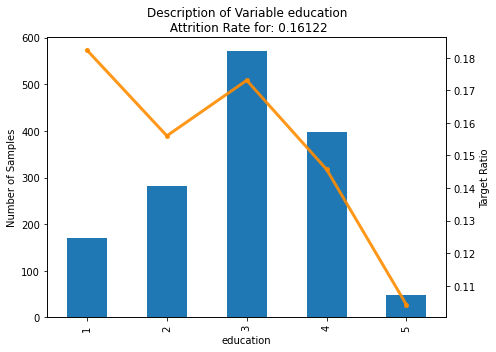

In [ ]:
plot_continuous(df, 'education', 'attrition')

                         attrition
environmentsatisfaction           
1                        25.352113
2                        14.982578
3                        13.686534
4                        13.452915


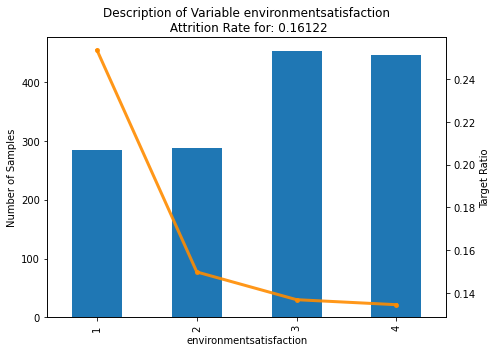

In [ ]:
plot_continuous(df, 'environmentsatisfaction', 'attrition')

                attrition
jobinvolvement           
1               33.734940
2               18.933333
3               14.400922
4                9.027778


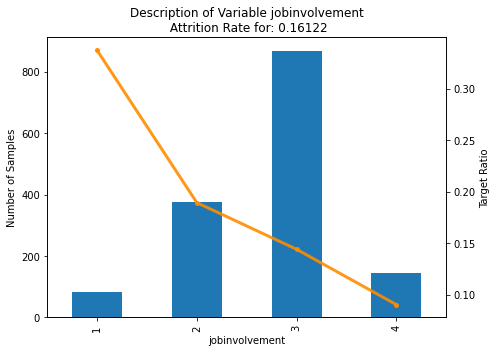

In [ ]:
plot_continuous(df, 'jobinvolvement', 'attrition')

          attrition
joblevel           
1         26.335175
2          9.737828
3         14.678899
4          4.716981
5          7.246377


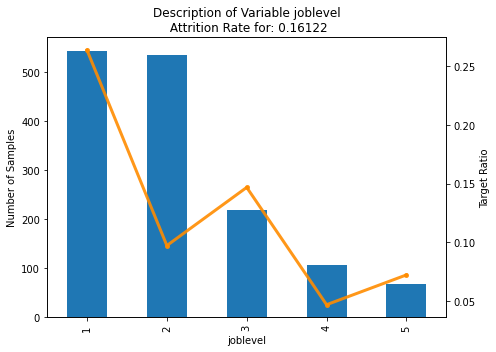

In [ ]:
plot_continuous(df, 'joblevel', 'attrition')

                 attrition
jobsatisfaction           
1                22.837370
2                16.428571
3                16.515837
4                11.328976


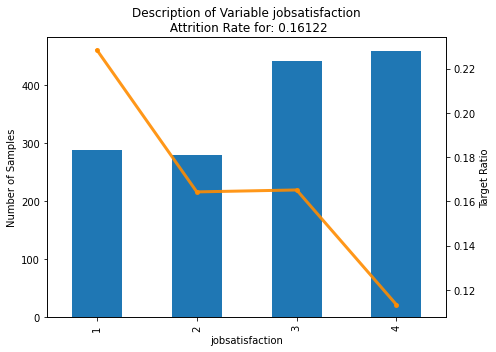

In [ ]:
plot_continuous(df, 'jobsatisfaction', 'attrition')

               attrition
monthlyincome           
1009               100.0
1051                 0.0
1052                 0.0
1081               100.0
1091               100.0
...                  ...
19859              100.0
19926                0.0
19943                0.0
19973                0.0
19999                0.0

[1349 rows x 1 columns]


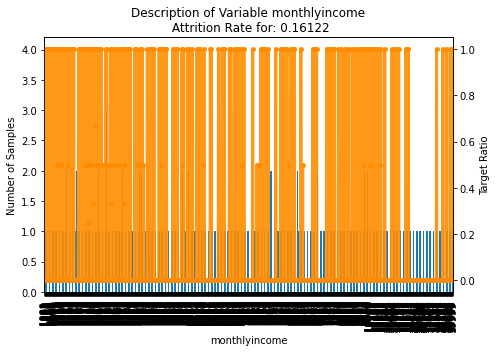

In [ ]:
plot_continuous(df, 'monthlyincome', 'attrition')

                    attrition
numcompaniesworked           
0                   11.675127
1                   18.809981
2                   10.958904
3                   10.062893
4                   12.230216
5                   25.396825
6                   22.857143
7                   22.972973
8                   12.244898
9                   23.076923


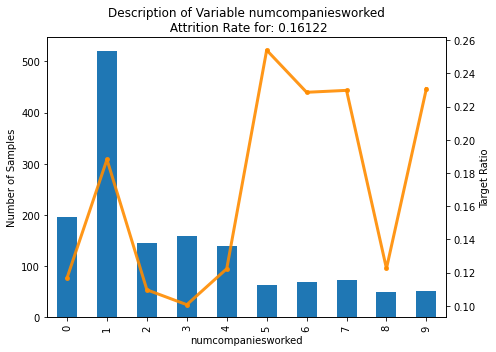

In [ ]:
plot_continuous(df, 'numcompaniesworked', 'attrition')

                   attrition
percentsalaryhike           
11                 19.523810
12                 16.666667
13                 16.267943
14                 11.940299
15                 17.821782
16                 17.948718
17                 17.073171
18                 14.606742
19                 11.842105
20                 12.727273
21                 10.416667
22                 21.428571
23                 21.428571
24                 28.571429
25                  5.555556


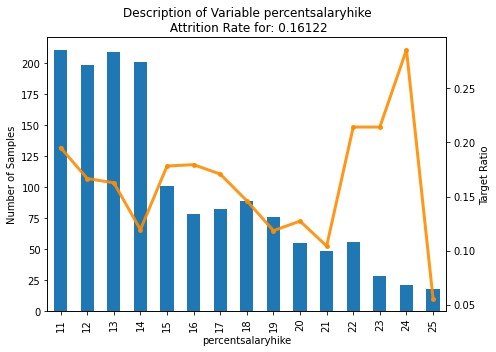

In [ ]:
plot_continuous(df, 'percentsalaryhike', 'attrition')

                   attrition
performancerating           
3                  16.077170
4                  16.371681


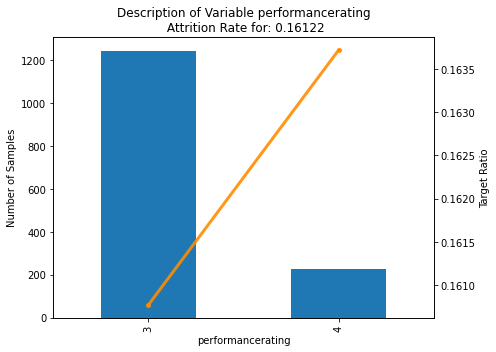

In [ ]:
plot_continuous(df, 'performancerating', 'attrition')

                          attrition
relationshipsatisfaction           
1                         20.652174
2                         14.851485
3                         15.468410
4                         14.814815


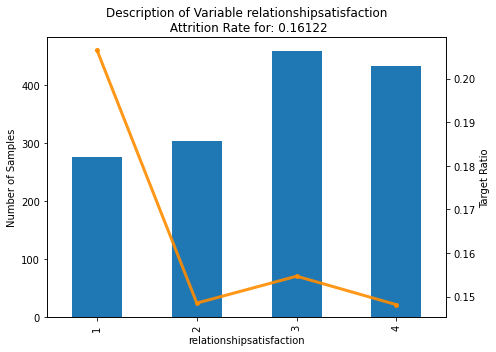

In [ ]:
plot_continuous(df, 'relationshipsatisfaction', 'attrition')

                  attrition
stockoptionlevel           
0                 24.405705
1                  9.395973
2                  7.594937
3                 17.647059


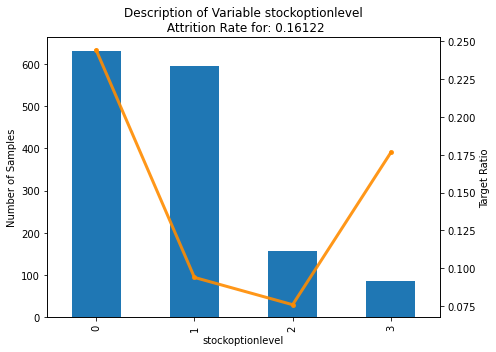

In [ ]:
plot_continuous(df, 'stockoptionlevel', 'attrition')

                    attrition
totalworkingyears            
0                   45.454545
1                   49.382716
2                   29.032258
3                   21.428571
4                   19.047619
5                   18.181818
6                   17.600000
7                   22.222222
8                   15.533981
9                   10.416667
10                  12.376238
11                  19.444444
12                  10.416667
13                   8.333333
14                  12.903226
15                  12.500000
16                   8.108108
17                   9.090909
18                  14.814815
19                  13.636364
20                   6.666667
21                   2.941176
22                   9.523810
23                   9.090909
24                  16.666667
25                   7.142857
26                   7.142857
27                   0.000000
28                   7.142857
29                   0.000000
30                   0.000000
31        

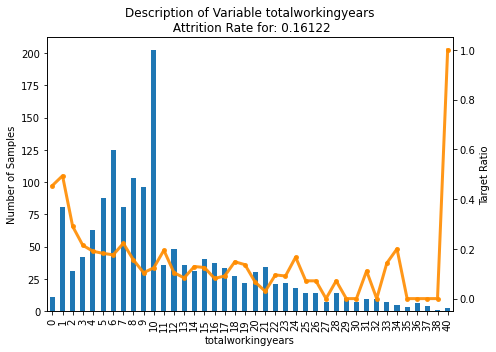

In [ ]:
plot_continuous(df, 'totalworkingyears', 'attrition')

                       attrition
trainingtimeslastyear           
0                      27.777778
1                      12.676056
2                      17.915905
3                      14.052953
4                      21.138211
5                      11.764706
6                       9.230769


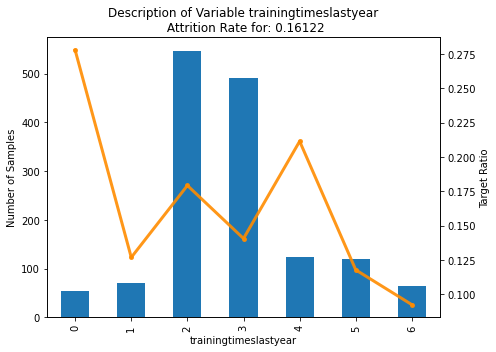

In [20]:
plot_continuous(df, 'trainingtimeslastyear', 'attrition')

                 attrition
worklifebalance           
1                31.250000
2                16.860465
3                14.221725
4                17.647059


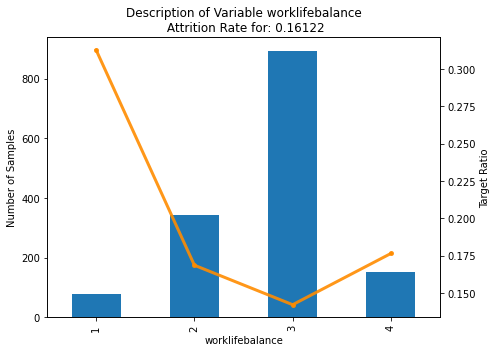

In [21]:
plot_continuous(df, 'worklifebalance', 'attrition')

                 attrition
yearsatcompany            
0                36.363636
1                34.502924
2                21.259843
3                15.625000
4                17.272727
5                10.714286
6                11.842105
7                12.222222
8                11.250000
9                 9.756098
10               15.000000
11                6.250000
12                0.000000
13                8.333333
14               11.111111
15                5.000000
16                8.333333
17               11.111111
18                7.692308
19                9.090909
20                3.703704
21                7.142857
22                6.666667
23               50.000000
24               16.666667
25                0.000000
26                0.000000
27                0.000000
29                0.000000
30                0.000000
31               33.333333
32               33.333333
33               20.000000
34                0.000000
36                0.000000
3

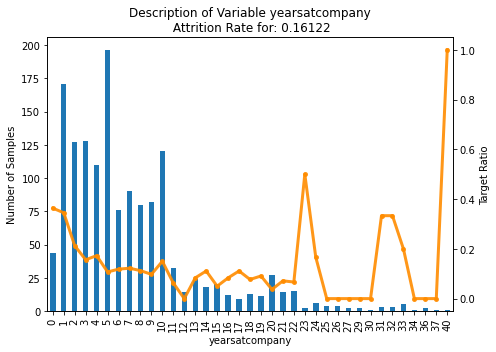

In [ ]:
plot_continuous(df, 'yearsatcompany', 'attrition')

                    attrition
yearsincurrentrole           
0                   29.918033
1                   19.298246
2                   18.279570
3                   11.851852
4                   14.423077
5                    2.777778
6                    5.405405
7                   13.963964
8                    7.865169
9                    8.955224
10                   6.896552
11                   0.000000
12                  10.000000
13                   7.142857
14                   9.090909
15                  25.000000
16                   0.000000
17                   0.000000
18                   0.000000


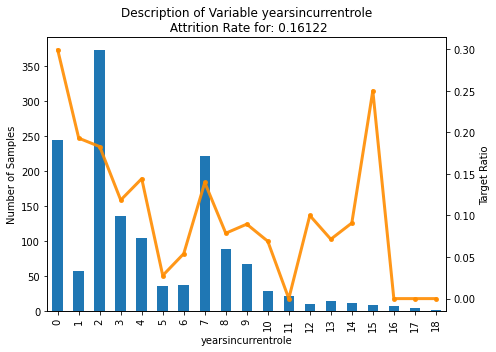

In [ ]:
plot_continuous(df, 'yearsincurrentrole', 'attrition')

                         attrition
yearssincelastpromotion           
0                        18.932874
1                        13.725490
2                        16.981132
3                        17.307692
4                         8.196721
5                         4.444444
6                        18.750000
7                        21.052632
8                         0.000000
9                        23.529412
10                       16.666667
11                        8.333333
12                        0.000000
13                       20.000000
14                       11.111111
15                       23.076923


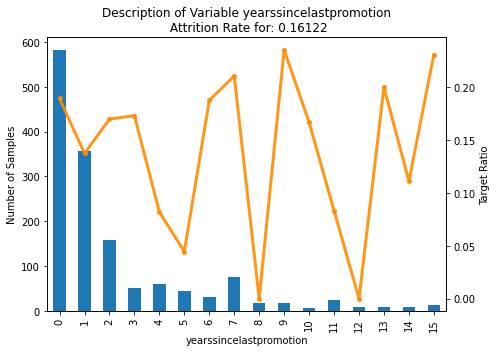

In [ ]:
plot_continuous(df, 'yearssincelastpromotion', 'attrition')

                      attrition
yearswithcurrmanager           
0                     32.319392
1                     14.473684
2                     14.534884
3                     13.380282
4                     11.224490
5                     12.903226
6                     13.793103
7                     14.351852
8                      9.345794
9                      9.375000
10                    11.111111
11                     4.545455
12                     0.000000
13                     0.000000
14                    40.000000
15                     0.000000
16                     0.000000
17                     0.000000


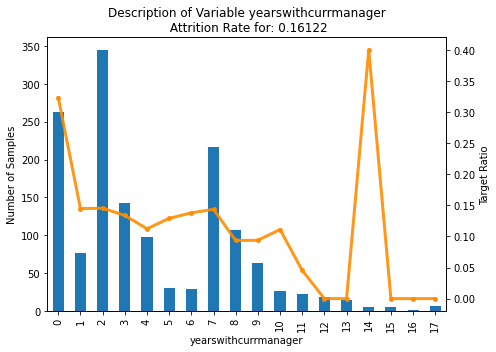

In [ ]:
plot_continuous(df, 'yearswithcurrmanager', 'attrition')

          attrition
overtime           
0         10.436433
1         30.528846


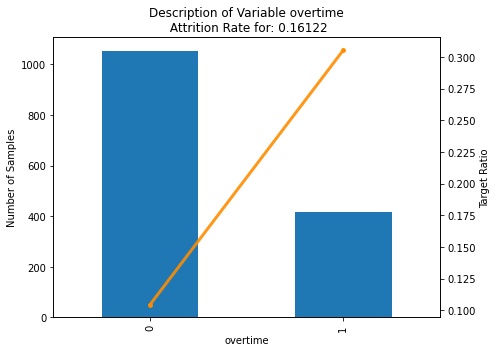

In [ ]:
plot_continuous(df, 'overtime', 'attrition')

In [ ]:
correlations = df.corr()['attrition'].sort_values()
print('Top Positive Correlations: \n', correlations.tail(5))
print('\n')
print('Top Negative Correlations: \n', correlations.head(5))

Top Positive Correlations: 
 performancerating     0.002889
numcompaniesworked    0.043494
distancefromhome      0.077924
overtime              0.246118
attrition             1.000000
Name: attrition, dtype: float64


Top Negative Correlations: 
 totalworkingyears    -0.171063
joblevel             -0.169105
yearsincurrentrole   -0.160545
monthlyincome        -0.159840
age                  -0.159205
Name: attrition, dtype: float64


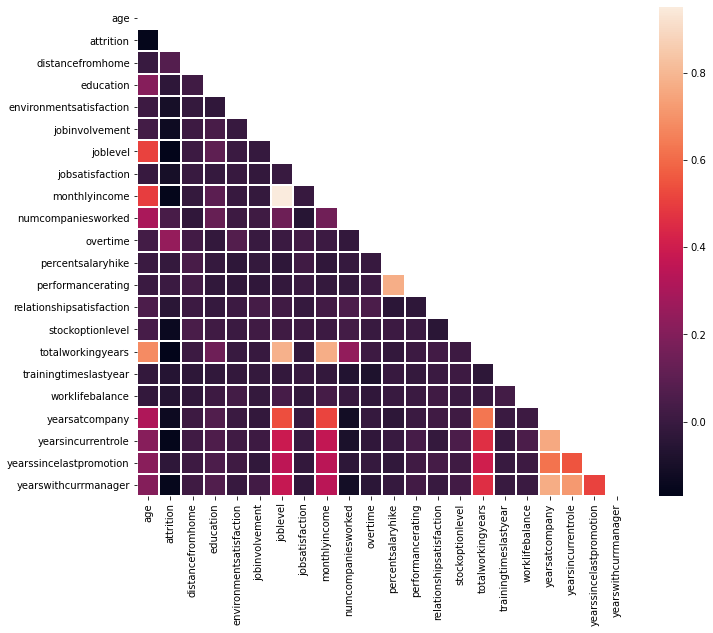

In [22]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, linewidths=.2);

## III. Preprocessing & Trying Algorithms
 Steps:
  - Encode categorical data using LabelEncoder
  - Scale data using MinMaxScaler
  - Split the data into training/test sets
  - Try out algorithms and asses performance

I'm going to use the following algorithms in my analysis:
 - Support Vector Machine
 - K Nearest Neighbors
 - Gaussian NB
 - Random Forest Classifier
 - Decision Tree Classifier
 - XGBoost Classifier

In [23]:
cat_data = df.copy()
label_encoder = LabelEncoder()
for col in categorical:
  cat_data[col] = label_encoder.fit_transform(df[col])

In [24]:
X = cat_data.drop(['attrition'], axis=1)
y = cat_data['attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X_train records: ', X_train.shape)
print('y_train records: ', y_train.shape)
print('X_test records: ', X_test.shape)
print('y_test records: ', y_test.shape)

X_train records:  (1176, 27)
y_train records:  (1176,)
X_test records:  (294, 27)
y_test records:  (294,)


In [25]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear',
                                                         random_state=42, 
                                                         class_weight='balanced')))

models.append(('SVM', SVC(gamma='auto', random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)))
models.append(('XGBoost Classifier', XGBClassifier(eval_metric='logloss',use_label_encoder=False)))

In [27]:
accuracy_scores = []
auc_scores = []
model_names = []

cols = ['Model Name', 'ROC AUC Mean', 'ROC AUC StDev', 'Accuracy Mean', 'Accuracy StDev']
results = pd.DataFrame(columns=cols)
i=0

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_accuracy_scores = model_selection.cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    cv_auc_scores = model_selection.cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    accuracy_scores.append(cv_accuracy_scores)
    auc_scores.append(cv_auc_scores)
    model_names.append(name)
    results.loc[i] = [name,
                      round(cv_auc_scores.mean()*100, 2),
                      round(cv_auc_scores.std()*100, 2),
                      round(cv_accuracy_scores.mean()*100, 2),
                      round(cv_accuracy_scores.std()*100, 2)]
    
    i += 1
    
results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Model Name,ROC AUC Mean,ROC AUC StDev,Accuracy Mean,Accuracy StDev
1,SVM,81.52,8.53,83.84,2.64
0,Logistic Regression,80.06,8.47,73.73,4.15
6,XGBoost Classifier,78.74,7.65,86.31,3.60
4,Random Forest Classifier,78.51,8.57,86.05,2.76
3,Gaussian NB,75.85,8.97,76.79,4.44
2,KNN,71.00,6.38,84.10,1.70
5,Decision Tree Classifier,60.25,4.16,78.31,2.25


**RESULTS!**

I am going to use the mean AUC scores to choose the algorithms with which to proceed to the next step. SVM, LogReg, and XGBoost all had the top scores, and I'll throw in RandomForest as well. I'll tune parameters for each, and assess performance again before choosing a final algorithm and making predictions.

**Support Vector Machine**

Best Parameters:  {'C': 100, 'gamma': 0.01}
Best Score:  0.8199671256062233
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.79      0.32      0.45        47

    accuracy                           0.88       294
   macro avg       0.84      0.65      0.69       294
weighted avg       0.87      0.88      0.85       294



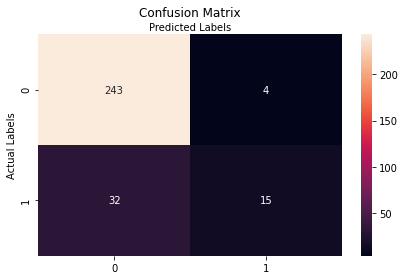

In [28]:
param_grid = {'C': [100, 10, 1.0, 0.1, 0.01],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

svc_gs = GridSearchCV(SVC(),
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

svc_grid = svc_gs.fit(X_train, y_train)
svc_optimal = svc_grid.best_estimator_
result = svc_gs.cv_results_

print('Best Parameters: ', svc_gs.best_params_)
print('Best Score: ', svc_gs.best_score_)

confusion_matrix = metrics.confusion_matrix(y_test, svc_optimal.predict(X_test))
classes = [0,1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.tight_layout();

svc_optimal.fit(X_train, y_train)
print(classification_report(y_test, svc_optimal.predict(X_test)))

**Logistic Regression**

Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  0.8085012314335623
Logistic Regression, Test Set - Accuracy Score: 88.78
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       247
           1       0.82      0.38      0.52        47

    accuracy                           0.89       294
   macro avg       0.86      0.68      0.73       294
weighted avg       0.88      0.89      0.87       294



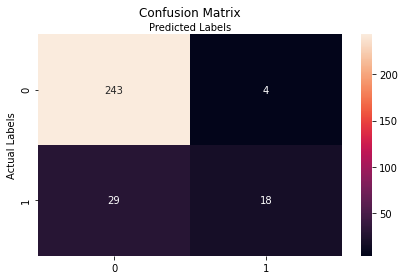

In [29]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [1000, 100, 10, 1, 0.1, 0.01],
              'solver': ['liblinear']}

logreg_gs = GridSearchCV(LogisticRegression(),
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

logreg_grid = logreg_gs.fit(X_train, y_train)
logreg_optimal = logreg_grid.best_estimator_
result = logreg_gs.cv_results_

print('Best Parameters: ', logreg_gs.best_params_)
print('Best Score: ', logreg_gs.best_score_)

confusion_matrix = metrics.confusion_matrix(y_test, logreg_optimal.predict(X_test))
classes = [0,1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.tight_layout();

print('Logistic Regression, Test Set - Accuracy Score: {:.2f}'.format(logreg_optimal.score(X_test, y_test)*100))

logreg_optimal.fit(X_train, y_train)
print(classification_report(y_test, logreg_optimal.predict(X_test)))

**XGBoost Classifier**

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[15:40:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

[15:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:41:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters:  {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4}
ROC AUC:  0.8187767334040377
XGBoost Classifier, Test Set - Accuracy Score: 85.37
[15:41:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


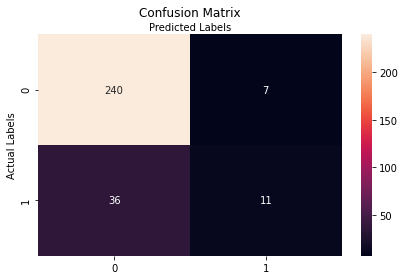

In [30]:
params = {'max_depth': [3, 5, 6, 10, 15, 20],
          'min_child_weight': [3, 5, 7, 9],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'n_estimators': [100, 500, 1000],
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'subsample': np.arange(0.5, 1.0, 0.1)}

xgb_clf = XGBClassifier(seed = 42)

clf = RandomizedSearchCV(estimator=xgb_clf,
                   param_distributions=params,
                   scoring='roc_auc',
                   n_iter=25,
                   verbose=1)

clf_randomized = clf.fit(X_train, y_train)
clf_optimal = clf_randomized.best_estimator_
result = clf.cv_results_

print('Best parameters: ', clf.best_params_)
print('ROC AUC: ', clf.best_score_)

confusion_matrix = metrics.confusion_matrix(y_test, clf_optimal.predict(X_test))
classes = [0,1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.tight_layout();

print('XGBoost Classifier, Test Set - Accuracy Score: {:.2f}'.format(clf_optimal.score(X_test, y_test)*100))

clf_optimal.fit(X_train, y_train)
print(classification_report(y_test, clf_optimal.predict(X_test)))

In [31]:
clf_optimal.feature_importances_

array([0.04462748, 0.03594804, 0.03935778, 0.03380635, 0.01556511,
       0.01371975, 0.04065632, 0.02398479, 0.05090335, 0.06045213,
       0.03473315, 0.03221877, 0.03290217, 0.04786294, 0.04565201,
       0.0719484 , 0.02109513, 0.01977803, 0.02608751, 0.05459413,
       0.0585532 , 0.02049111, 0.04077988, 0.04899361, 0.02827185,
       0.0227055 , 0.03431153], dtype=float32)

In [32]:
feature_names = X.columns

In [33]:
explainer = shap.Explainer(clf_optimal, feature_names=feature_names)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [34]:
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_train_df.head()

,age,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,0.690476,1.0,1.0,0.035714,0.75,0.2,0.333333,0.0,1.000000,0.75,0.375,0.333333,0.0,0.789021,0.666667,0.0,0.214286,0.0,0.666667,1.000000,0.725,0.333333,0.666667,0.081081,0.117647,0.066667,0.117647
1,0.095238,1.0,0.5,0.035714,0.00,1.0,0.666667,1.0,0.666667,0.00,0.250,1.000000,0.5,0.079835,0.000000,0.0,0.214286,0.0,0.666667,0.333333,0.075,0.333333,0.666667,0.054054,0.058824,0.133333,0.058824
2,0.666667,1.0,1.0,0.071429,0.00,0.4,0.000000,1.0,0.666667,0.75,0.375,0.666667,0.5,0.867749,0.333333,0.0,0.071429,0.0,1.000000,0.333333,0.575,0.500000,0.666667,0.324324,0.529412,0.266667,0.529412
3,0.166667,1.0,1.0,0.428571,0.00,0.6,0.333333,1.0,0.666667,0.00,1.000,0.666667,0.5,0.057319,0.111111,0.0,0.000000,0.0,0.666667,0.000000,0.175,0.166667,0.666667,0.189189,0.235294,0.000000,0.352941
4,0.595238,0.5,0.5,0.285714,1.00,0.6,1.000000,1.0,0.666667,0.25,0.250,0.666667,0.0,0.246256,0.333333,1.0,0.142857,0.0,0.333333,0.333333,0.250,0.500000,0.666667,0.216216,0.411765,0.266667,0.411765


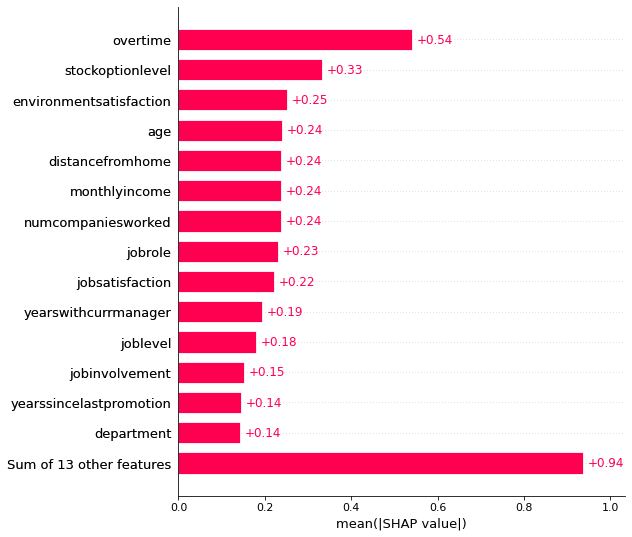

In [35]:
shap.plots.bar(shap_values, max_display=15)

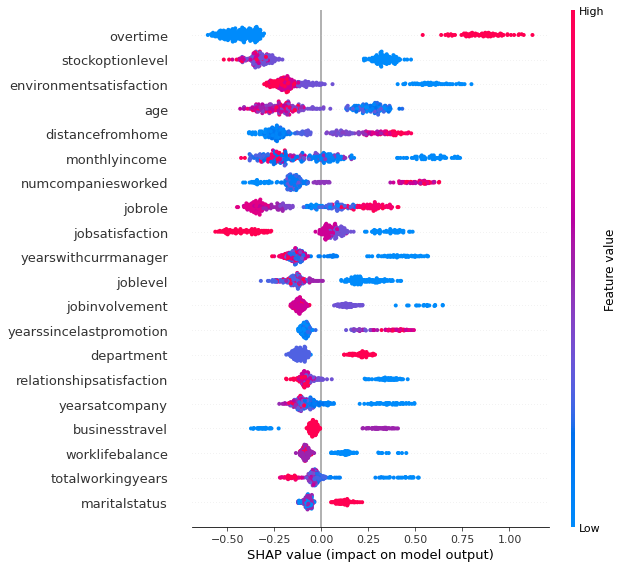

In [36]:
shap.summary_plot(shap_values, X_test)

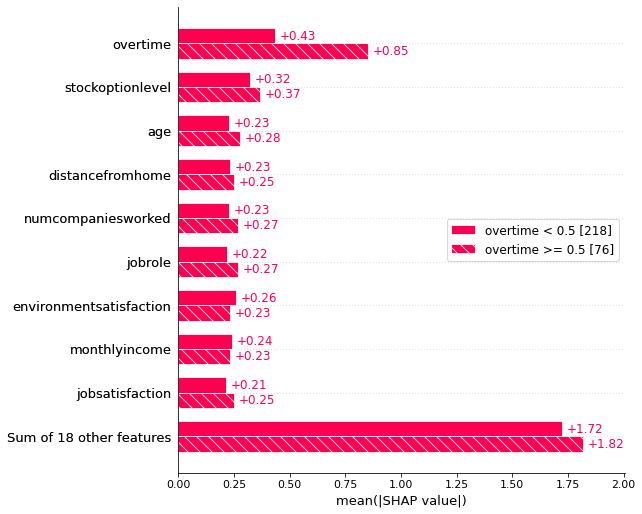

In [38]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

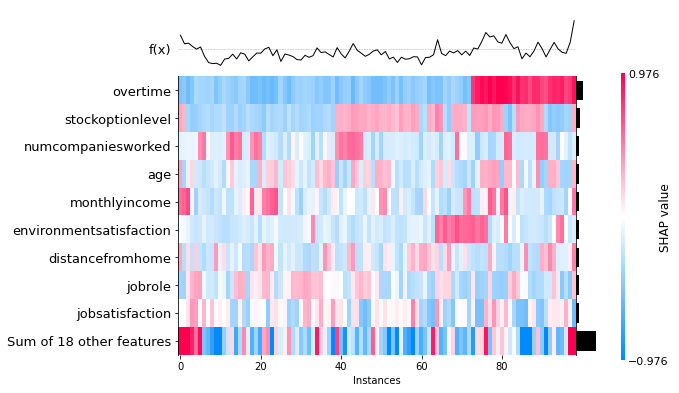

In [39]:
shap.plots.heatmap(shap_values[1:100])

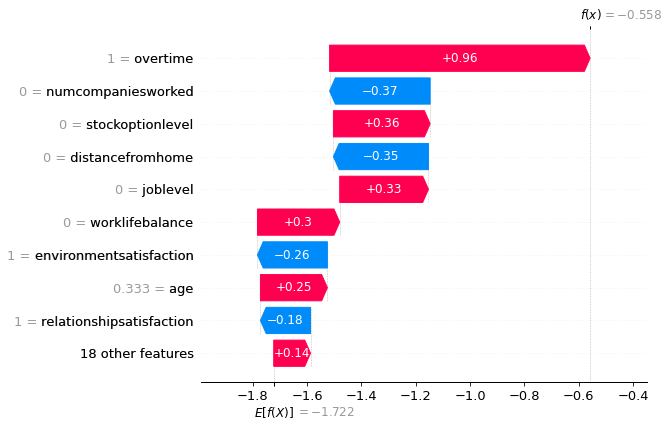

In [40]:
shap.plots.waterfall(shap_values[250])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


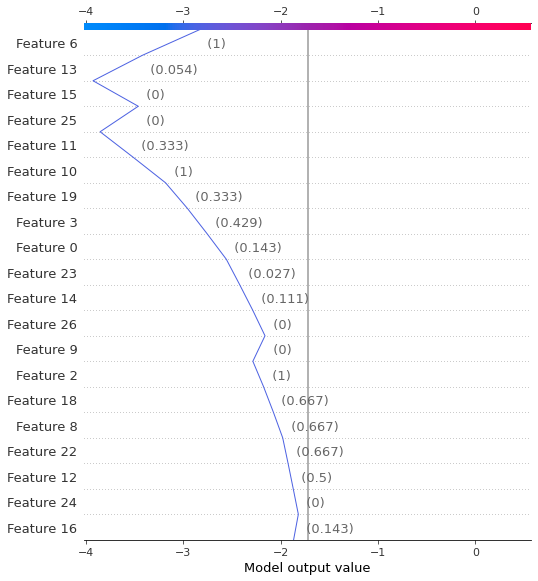

In [41]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[1], X_test)

In [ ]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(clf_optimal, open(filename, 'wb'))

In [ ]:
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))